# Bike Sharing Demand-EDA

### Gerekli kütüphanele

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.shape,test.shape

((10886, 12), (6493, 9))

In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Veri ön işleme

In [16]:
def preprocess_data(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['weekday'] = df['datetime'].dt.weekday

    # İş günü ya da tatil mi? (1 = iş günü ve tatil değil, 0 = tatil veya hafta sonu)
    df['is_business_day'] = ((df['weekday'] < 5) & (df['holiday'] == 0)).astype(int)

    # Mevsimsel özellikler
    df['season_spring'] = (df['season'] == 1).astype(int)
    df['season_summer'] = (df['season'] == 2).astype(int)
    df['season_fall'] = (df['season'] == 3).astype(int)
    df['season_winter'] = (df['season'] == 4).astype(int)

    # Hava durumu özellikleri
    df['weather_clear'] = (df['weather'] == 1).astype(int)
    df['weather_mist'] = (df['weather'] == 2).astype(int)
    df['weather_light_rain_snow'] = (df['weather'] == 3).astype(int)
    df['weather_heavy_rain_snow'] = (df['weather'] == 4).astype(int)

    # Sabah, öğle, akşam, gece
    df['time_of_day'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'])

    # Sıcaklık, nem ve rüzgar için oransal özellikler
    df['temp_ratio'] = df['temp'] / df['atemp']

    return df

In [11]:
train = preprocess_data(train)
test = preprocess_data(test)

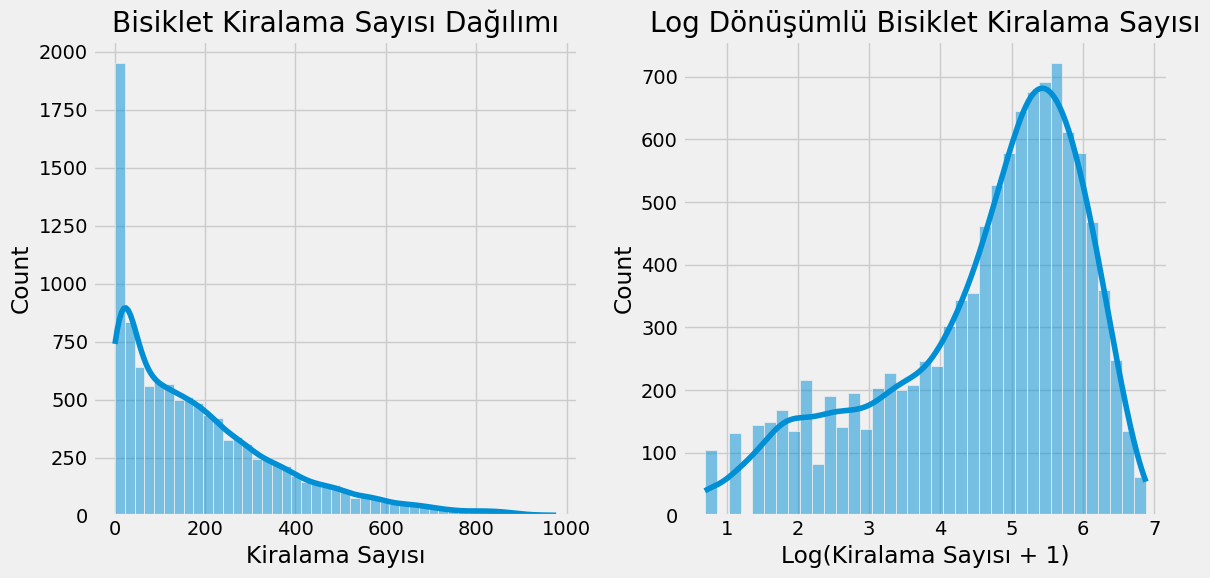

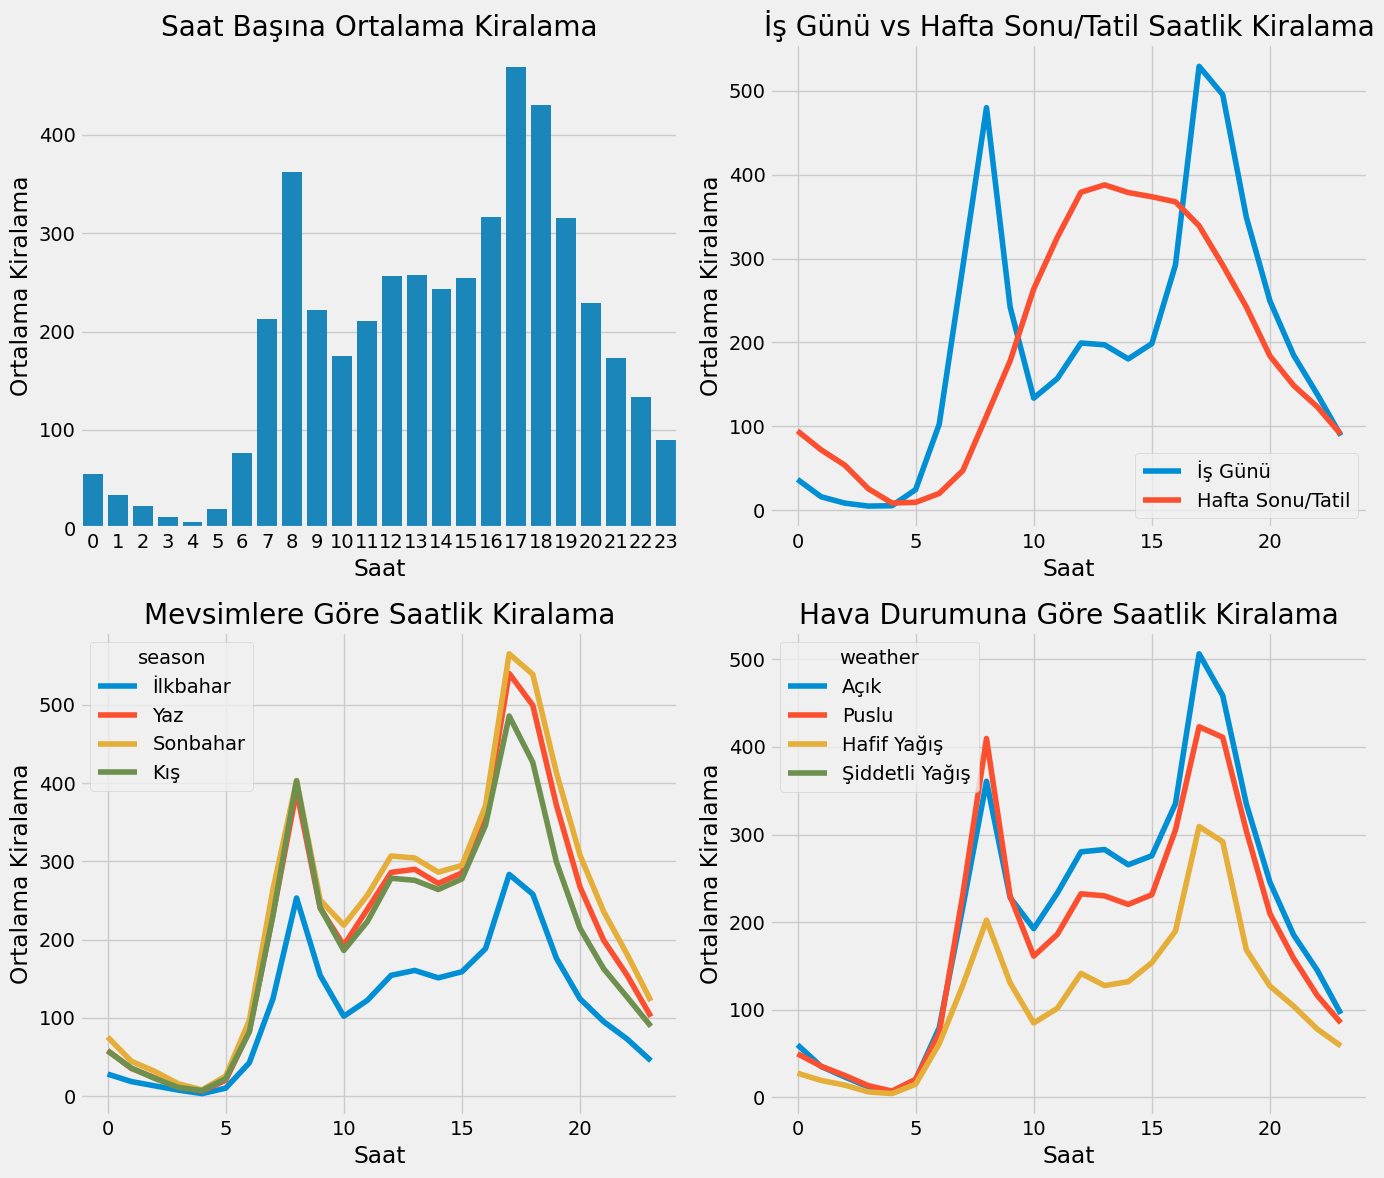

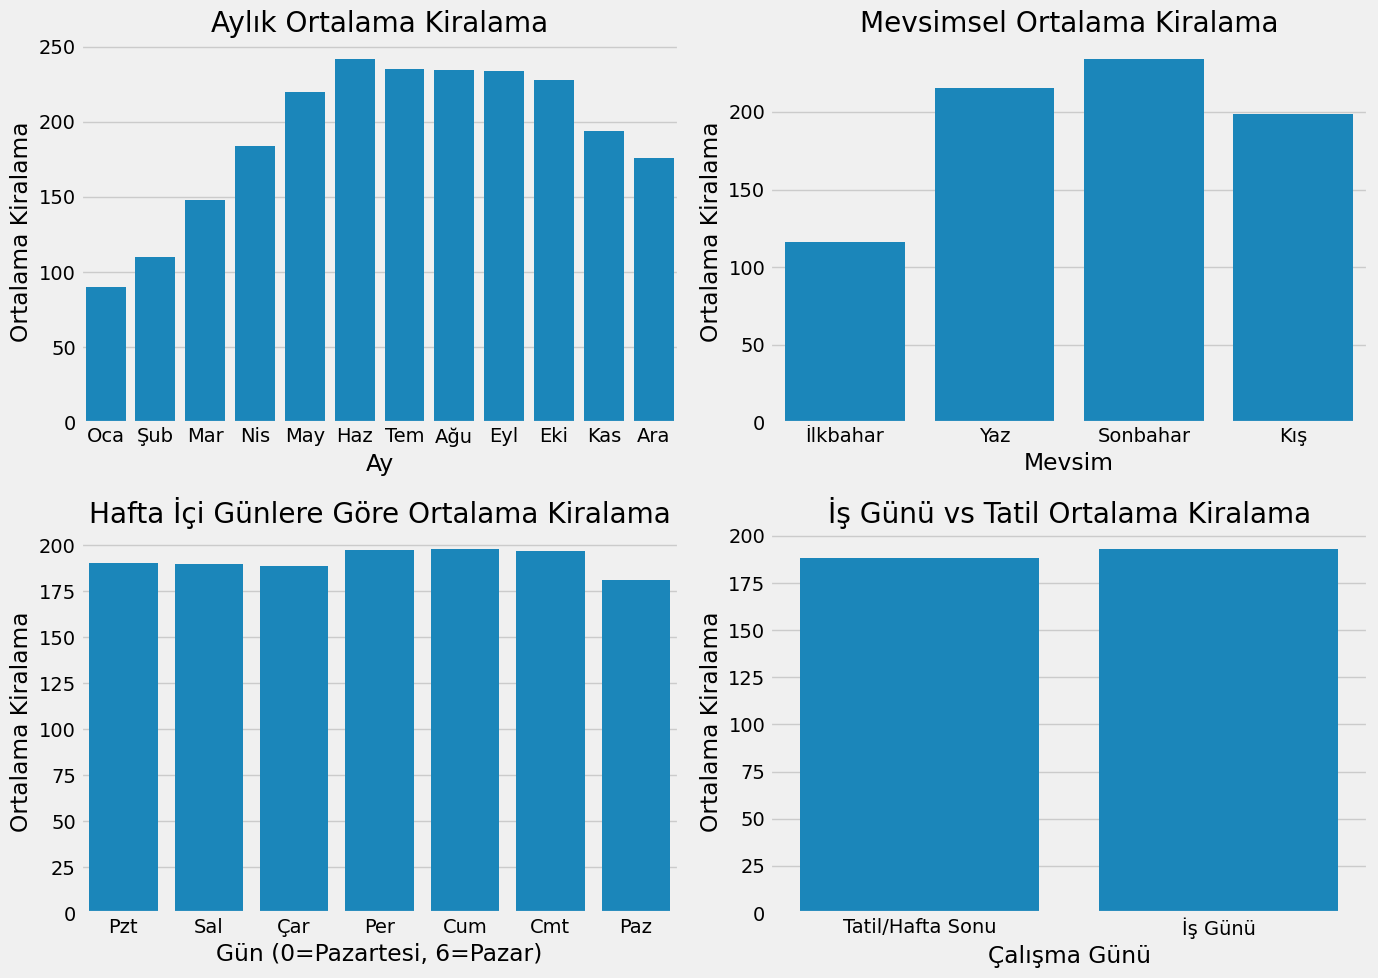

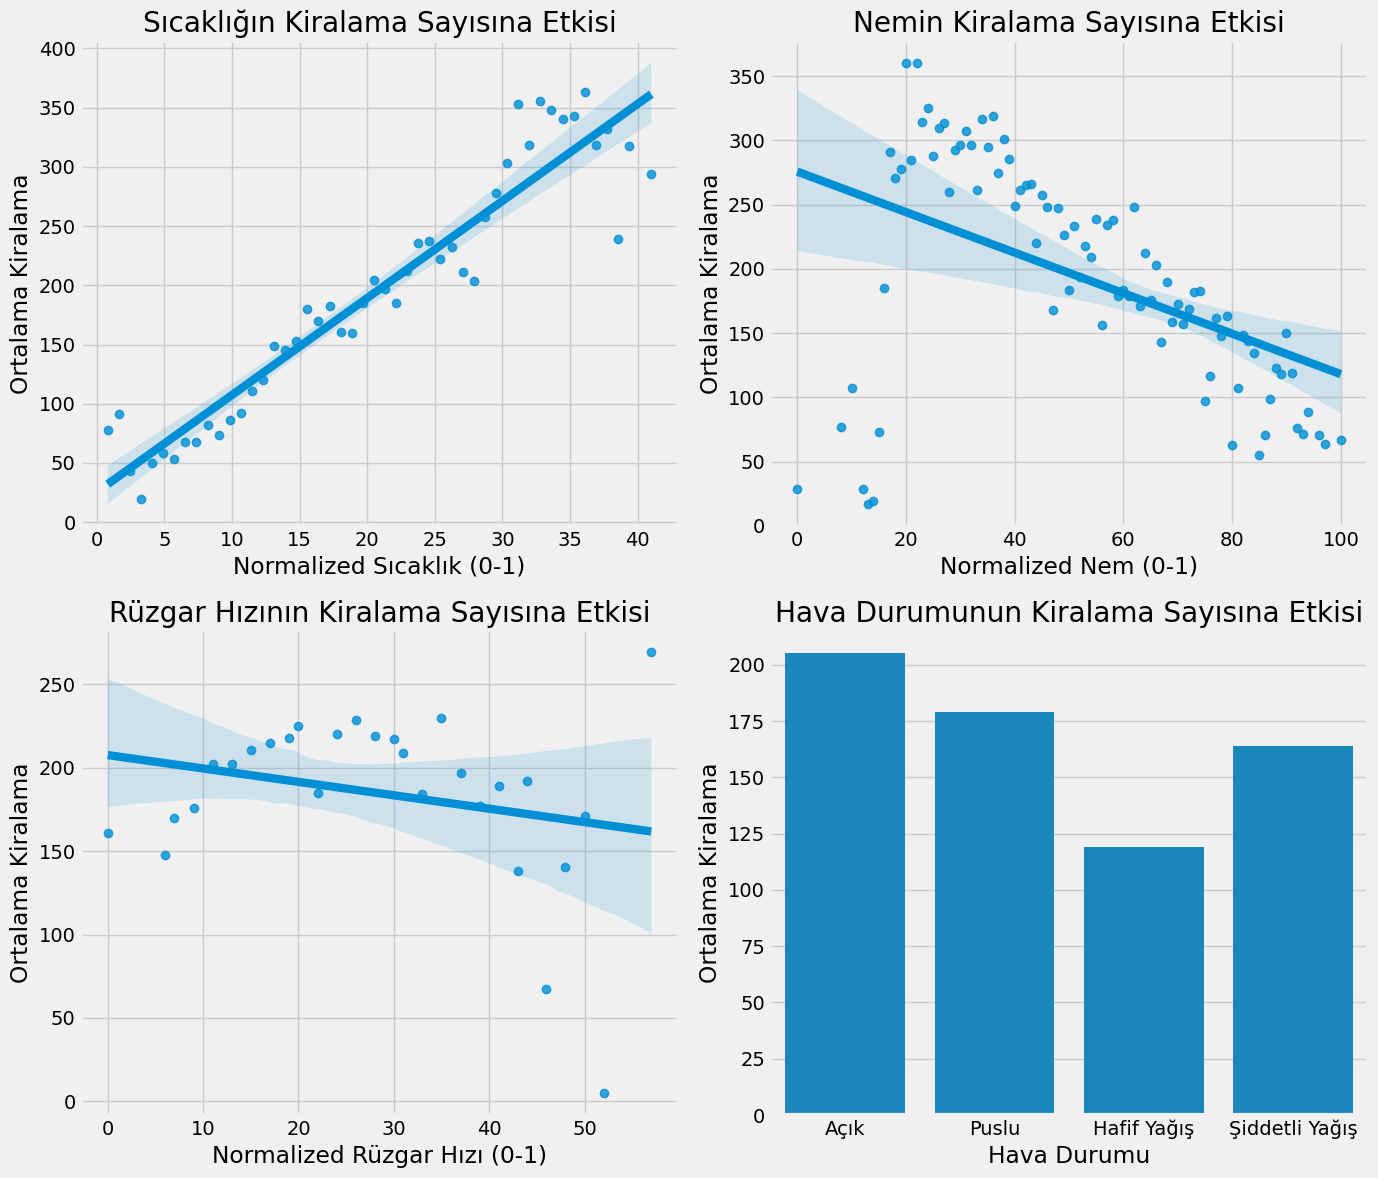

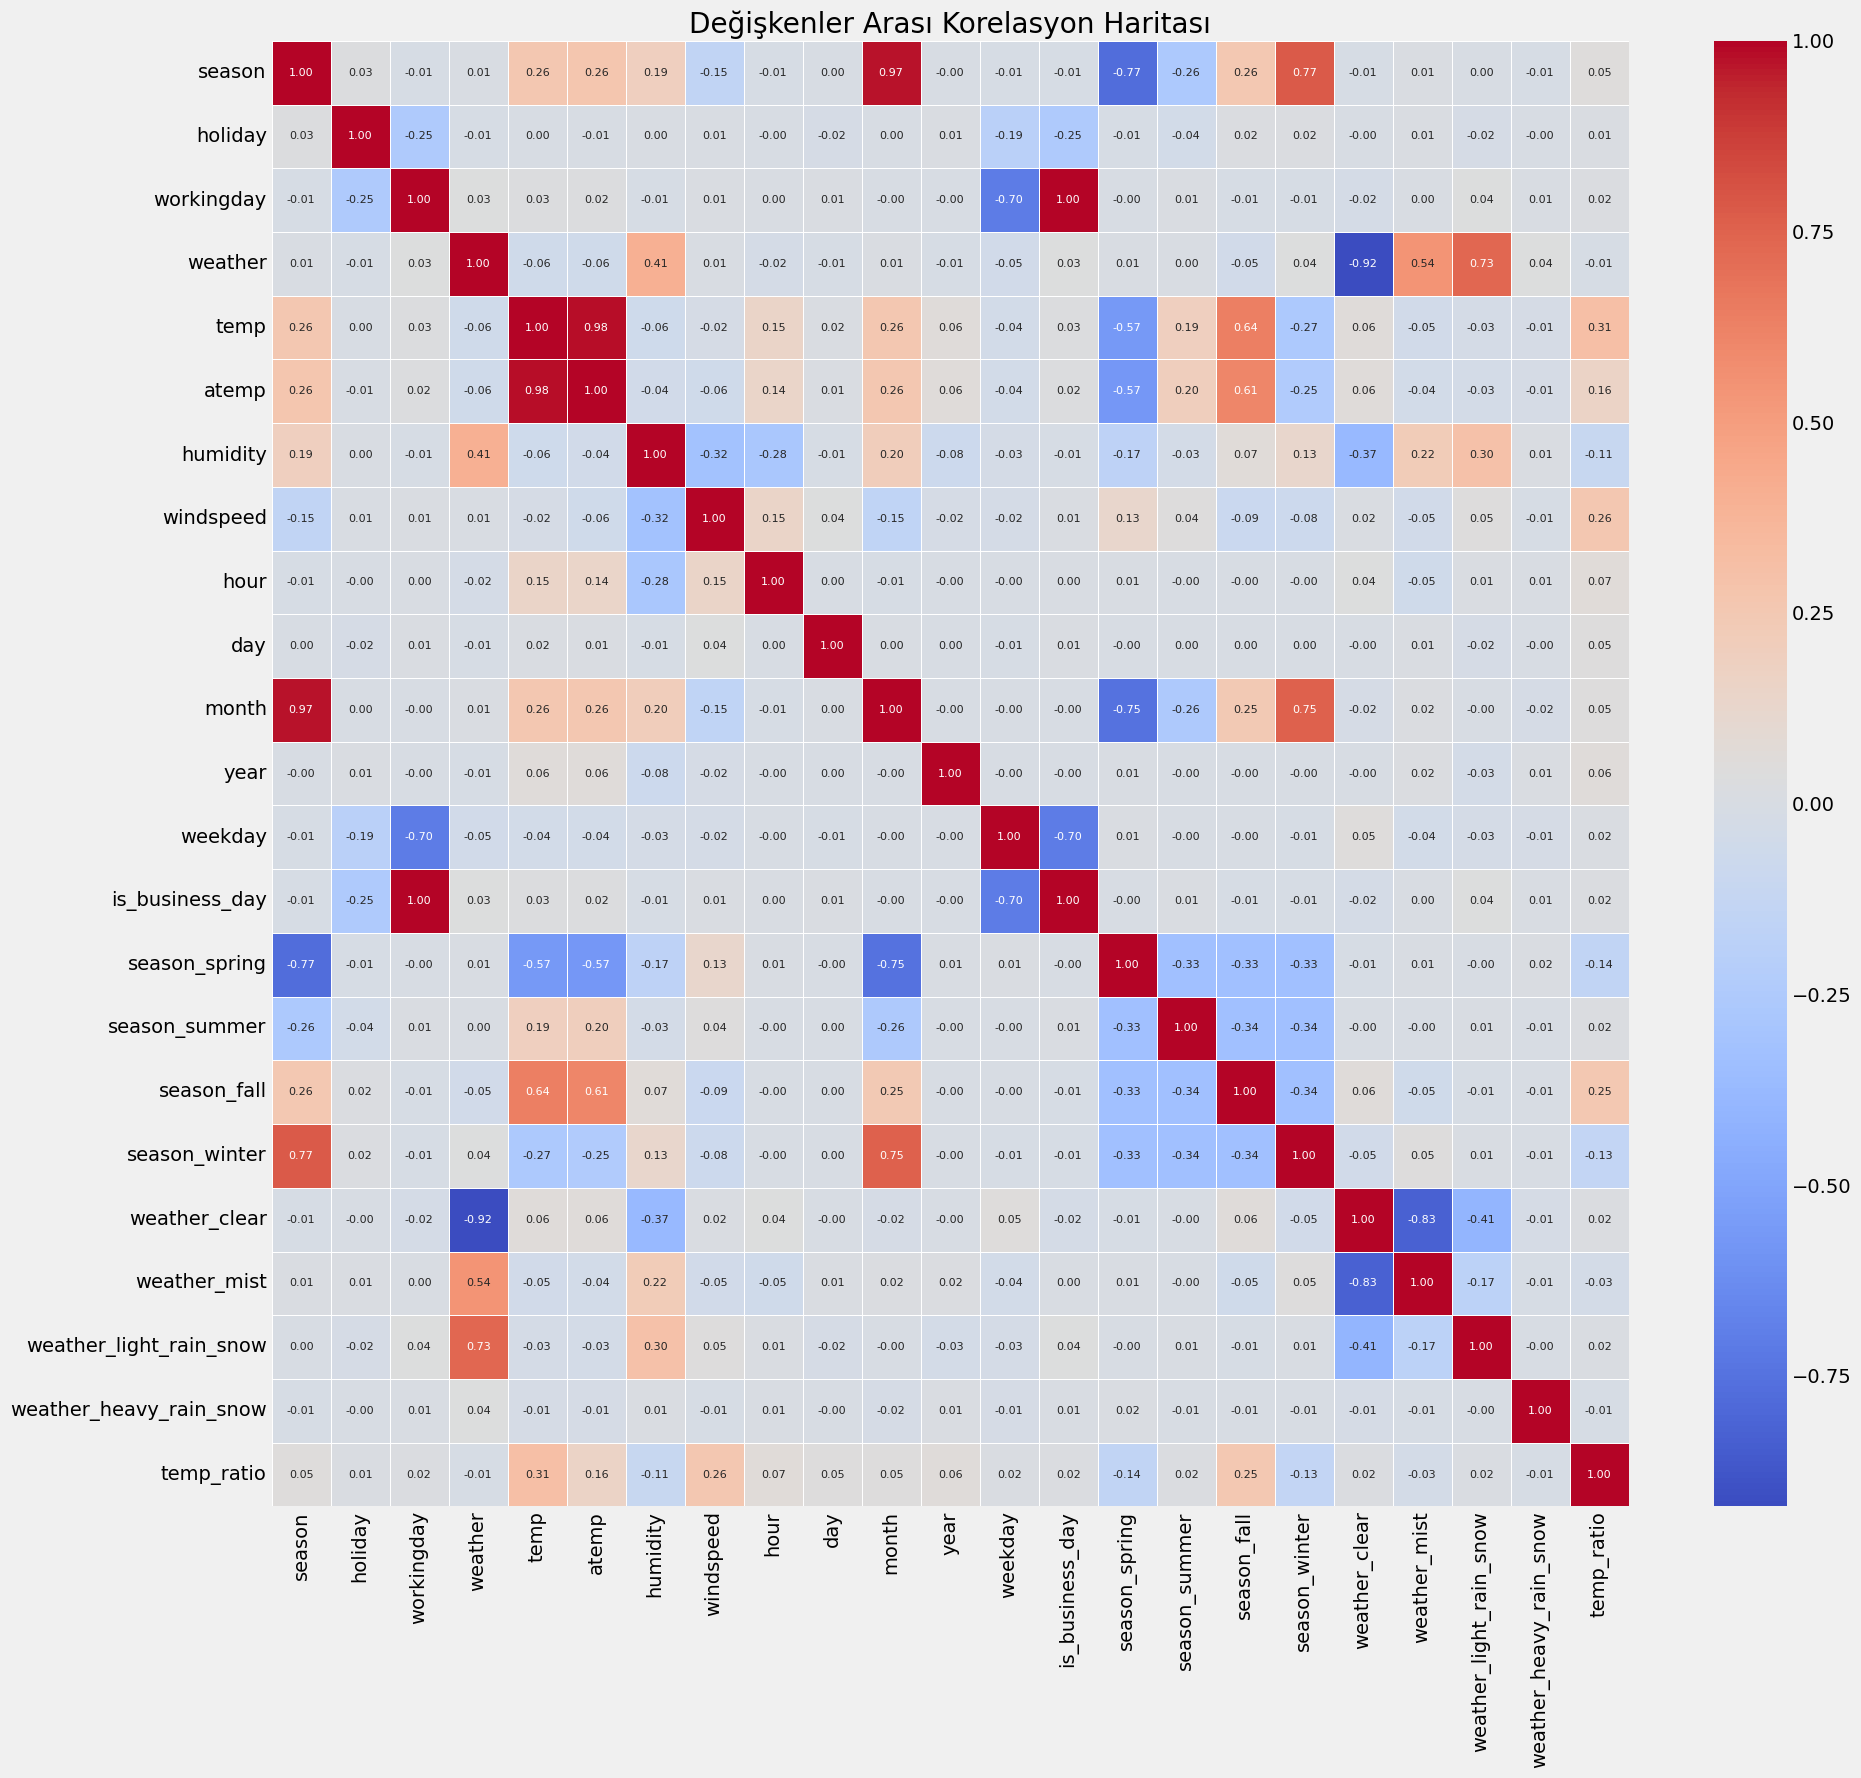

In [13]:
seasons = {1: 'İlkbahar', 2: 'Yaz', 3: 'Sonbahar', 4: 'Kış'}
weather_types = {1: 'Açık', 2: 'Puslu', 3: 'Hafif Yağış', 4: 'Şiddetli Yağış'}

# 1. Bisiklet kiralama sayısı dağılımı
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train['count'], kde=True)
plt.title('Bisiklet Kiralama Sayısı Dağılımı')
plt.xlabel('Kiralama Sayısı')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train['count']), kde=True)
plt.title('Log Dönüşümlü Bisiklet Kiralama Sayısı')
plt.xlabel('Log(Kiralama Sayısı + 1)')
plt.tight_layout()
plt.show()

# 2. Saatlik trendler - daha detaylı analiz
plt.figure(figsize=(14, 12))

# Saat başına ortalama kiralama
plt.subplot(2, 2, 1)
hour_data = train.groupby('hour')['count'].mean().reset_index()
sns.barplot(x='hour', y='count', data=hour_data)
plt.title('Saat Başına Ortalama Kiralama')
plt.xlabel('Saat')
plt.ylabel('Ortalama Kiralama')

# İş günü vs hafta sonu saatlik kiralama
plt.subplot(2, 2, 2)
hour_workday = train[train['workingday'] == 1].groupby('hour')['count'].mean().reset_index()
hour_non_workday = train[train['workingday'] == 0].groupby('hour')['count'].mean().reset_index()

sns.lineplot(x='hour', y='count', data=hour_workday, label='İş Günü')
sns.lineplot(x='hour', y='count', data=hour_non_workday, label='Hafta Sonu/Tatil')
plt.title('İş Günü vs Hafta Sonu/Tatil Saatlik Kiralama')
plt.xlabel('Saat')
plt.ylabel('Ortalama Kiralama')
plt.legend()

# Mevsimlere göre saatlik kiralama
plt.subplot(2, 2, 3)
seasonal_hour = train.groupby(['season', 'hour'])['count'].mean().reset_index()
seasonal_hour['season'] = seasonal_hour['season'].map(seasons)

sns.lineplot(x='hour', y='count', hue='season', data=seasonal_hour)
plt.title('Mevsimlere Göre Saatlik Kiralama')
plt.xlabel('Saat')
plt.ylabel('Ortalama Kiralama')

# Hava durumuna göre saatlik kiralama
plt.subplot(2, 2, 4)
weather_hour = train.groupby(['weather', 'hour'])['count'].mean().reset_index()
weather_hour['weather'] = weather_hour['weather'].map(weather_types)

sns.lineplot(x='hour', y='count', hue='weather', data=weather_hour)
plt.title('Hava Durumuna Göre Saatlik Kiralama')
plt.xlabel('Saat')
plt.ylabel('Ortalama Kiralama')

plt.tight_layout()
plt.show()

# 3. Aylık ve mevsimsel trendler
plt.figure(figsize=(14, 10))

# Aylık ortalama kiralama
plt.subplot(2, 2, 1)
month_data = train.groupby('month')['count'].mean().reset_index()
sns.barplot(x='month', y='count', data=month_data)
plt.title('Aylık Ortalama Kiralama')
plt.xlabel('Ay')
plt.ylabel('Ortalama Kiralama')
plt.xticks(range(12), ['Oca', 'Şub', 'Mar', 'Nis', 'May', 'Haz', 'Tem', 'Ağu', 'Eyl', 'Eki', 'Kas', 'Ara'])

# Mevsimsel ortalama kiralama
plt.subplot(2, 2, 2)
season_data = train.groupby('season')['count'].mean().reset_index()
season_data['season'] = season_data['season'].map(seasons)
sns.barplot(x='season', y='count', data=season_data)
plt.title('Mevsimsel Ortalama Kiralama')
plt.xlabel('Mevsim')
plt.ylabel('Ortalama Kiralama')

# Hafta içi günlere göre ortalama kiralama
plt.subplot(2, 2, 3)
weekday_data = train.groupby('weekday')['count'].mean().reset_index()
sns.barplot(x='weekday', y='count', data=weekday_data)
plt.title('Hafta İçi Günlere Göre Ortalama Kiralama')
plt.xlabel('Gün (0=Pazartesi, 6=Pazar)')
plt.ylabel('Ortalama Kiralama')
plt.xticks(range(7), ['Pzt', 'Sal', 'Çar', 'Per', 'Cum', 'Cmt', 'Paz'])

# İş günü vs tatil ortalama kiralama
plt.subplot(2, 2, 4)
workingday_data = train.groupby('workingday')['count'].mean().reset_index()
workingday_data['workingday'] = workingday_data['workingday'].map({0: 'Tatil/Hafta Sonu', 1: 'İş Günü'})
sns.barplot(x='workingday', y='count', data=workingday_data)
plt.title('İş Günü vs Tatil Ortalama Kiralama')
plt.xlabel('Çalışma Günü')
plt.ylabel('Ortalama Kiralama')

plt.tight_layout()
plt.show()

# 4. Hava durumu etkisi
plt.figure(figsize=(14, 12))

# Sıcaklığın kiralama sayısına etkisi
plt.subplot(2, 2, 1)
temp_data = train.groupby('temp')['count'].mean().reset_index()
sns.regplot(x='temp', y='count', data=temp_data)
plt.title('Sıcaklığın Kiralama Sayısına Etkisi')
plt.xlabel('Normalized Sıcaklık (0-1)')
plt.ylabel('Ortalama Kiralama')

# Nemin kiralama sayısına etkisi
plt.subplot(2, 2, 2)
humidity_data = train.groupby('humidity')['count'].mean().reset_index()
sns.regplot(x='humidity', y='count', data=humidity_data)
plt.title('Nemin Kiralama Sayısına Etkisi')
plt.xlabel('Normalized Nem (0-1)')
plt.ylabel('Ortalama Kiralama')

# Rüzgar hızının kiralama sayısına etkisi
plt.subplot(2, 2, 3)
windspeed_data = train.groupby('windspeed')['count'].mean().reset_index()
sns.regplot(x='windspeed', y='count', data=windspeed_data)
plt.title('Rüzgar Hızının Kiralama Sayısına Etkisi')
plt.xlabel('Normalized Rüzgar Hızı (0-1)')
plt.ylabel('Ortalama Kiralama')

# Hava durumunun kiralama sayısına etkisi
plt.subplot(2, 2, 4)
weather_data = train.groupby('weather')['count'].mean().reset_index()
weather_data['weather'] = weather_data['weather'].map(weather_types)
sns.barplot(x='weather', y='count', data=weather_data)
plt.title('Hava Durumunun Kiralama Sayısına Etkisi')
plt.xlabel('Hava Durumu')
plt.ylabel('Ortalama Kiralama')

plt.tight_layout()
plt.show()

# 5. Korelasyon haritası
plt.figure(figsize=(20, 18))
numeric_df = train.select_dtypes(include=[np.number]).drop(columns=['count', 'casual', 'registered'], errors='ignore')
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', annot_kws={'size':8})
plt.title('Değişkenler Arası Korelasyon Haritası')
plt.tight_layout()
plt.show()

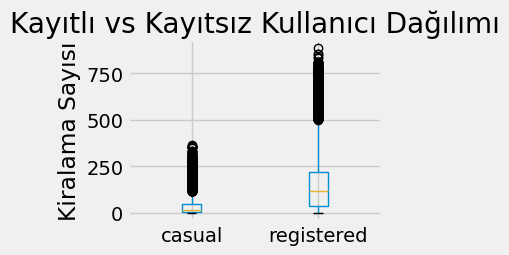

In [17]:
# Kayıtlı vs kayıtsız kullanıcı dağılımı
plt.subplot(2, 2, 4)
train[['casual', 'registered']].boxplot()
plt.title('Kayıtlı vs Kayıtsız Kullanıcı Dağılımı')
plt.ylabel('Kiralama Sayısı')

plt.tight_layout()
plt.show()

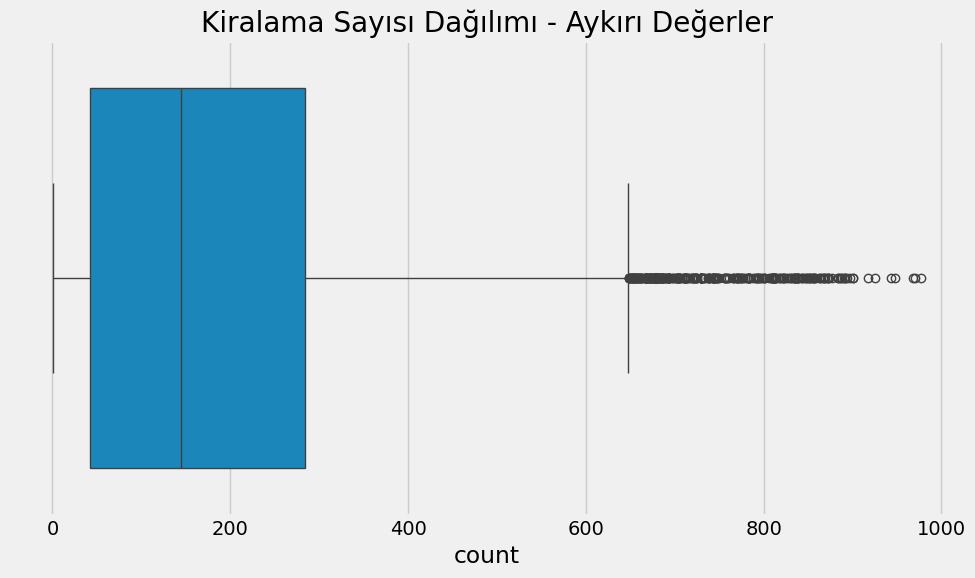

In [19]:
# Aykırı değerleri inceleme
plt.figure(figsize=(10, 6))
sns.boxplot(x=train['count'])
plt.title('Kiralama Sayısı Dağılımı - Aykırı Değerler')
plt.tight_layout()
plt.show()

In [21]:
# Aykırı değerleri temizleme (çok yüksek değerleri filtreleme)
q3 = train['count'].quantile(0.75)
iqr = train['count'].quantile(0.75) - train['count'].quantile(0.25)
upper_limit = q3 + 1.5 * iqr

train_cleaned = train[train['count'] <= upper_limit].copy()
print(f"Temizlenen veri sayısı: {train.shape[0] - train_cleaned.shape[0]}")

Temizlenen veri sayısı: 300


In [23]:
# Hedef değişkene logaritmik dönüşüm uygulama (RMSLE için önemli)
train_cleaned['count_log'] = np.log1p(train_cleaned['count'])

# Özellik seçimi ve kategorik değişkenleri one-hot encoding ile dönüştürme
print("\nÖzellik seçimi ve dönüşümü...")
feature_columns = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
                  'humidity', 'windspeed', 'hour', 'day', 'month', 'year', 'weekday',
                  'is_business_day', 'season_spring', 'season_summer', 'season_fall',
                  'season_winter', 'weather_clear', 'weather_mist', 'weather_light_rain_snow',
                  'weather_heavy_rain_snow', 'temp_ratio', 'time_of_day']

categorical_columns = ['season', 'holiday', 'workingday', 'weather', 'time_of_day']


Özellik seçimi ve dönüşümü...


In [25]:
# Özellik matrisi ve hedef değişkeni belirleme
X = train_cleaned[feature_columns].copy()
y = train_cleaned['count_log']

In [27]:
# Kategorik değişkenleri one-hot encoding ile dönüştürme
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [30]:
# 1. Random Forest Regressor
print("\n1. Random Forest modeli eğitiliyor...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Random Forest değerlendirme
rf_val_pred = rf_model.predict(X_val)
rf_val_pred_exp = np.expm1(rf_val_pred)  # Logaritmik dönüşümü geri al
y_val_exp = np.expm1(y_val)
rf_rmse = np.sqrt(mean_squared_log_error(y_val_exp, rf_val_pred_exp))
print(f"Random Forest Validation RMSLE: {rf_rmse:.5f}")

# 2. Gradient Boosting Regressor
print("\n2. Gradient Boosting modeli eğitiliyor...")
gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Gradient Boosting değerlendirme
gb_val_pred = gb_model.predict(X_val)
gb_val_pred_exp = np.expm1(gb_val_pred)
gb_rmse = np.sqrt(mean_squared_log_error(y_val_exp, gb_val_pred_exp))
print(f"Gradient Boosting Validation RMSLE: {gb_rmse:.5f}")

# 4. LightGBM modeli
print("\n4. LightGBM modeli eğitiliyor...")
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 40,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)

# LightGBM değerlendirme
lgb_val_pred = lgb_model.predict(X_val)
lgb_val_pred_exp = np.expm1(lgb_val_pred)
lgb_rmse = np.sqrt(mean_squared_log_error(y_val_exp, lgb_val_pred_exp))
print(f"LightGBM Validation RMSLE: {lgb_rmse:.5f}")


1. Random Forest modeli eğitiliyor...
Random Forest Validation RMSLE: 0.29686

2. Gradient Boosting modeli eğitiliyor...
Gradient Boosting Validation RMSLE: 0.28403

4. LightGBM modeli eğitiliyor...
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.369037	valid_1's rmse: 0.38335
[100]	training's rmse: 0.271983	valid_1's rmse: 0.304174
[150]	training's rmse: 0.243437	valid_1's rmse: 0.286339
[200]	training's rmse: 0.226341	valid_1's rmse: 0.279485
[250]	training's rmse: 0.213835	valid_1's rmse: 0.276025
[300]	training's rmse: 0.203545	valid_1's rmse: 0.274086
[350]	training's rmse: 0.194349	valid_1's rmse: 0.272882
[400]	training's rmse: 0.186265	valid_1's rmse: 0.272421
[450]	training's rmse: 0.179021	valid_1's rmse: 0.272488
[500]	training's rmse: 0.172867	valid_1's rmse: 0.271504
[550]	training's rmse: 0.167345	valid_1's rmse: 0.271938
Early stopping, best iteration is:
[517]	training's rmse: 0.170741	valid_1's rmse: 0.271222
LightGBM Validation RM

<Figure size 1200x1000 with 0 Axes>

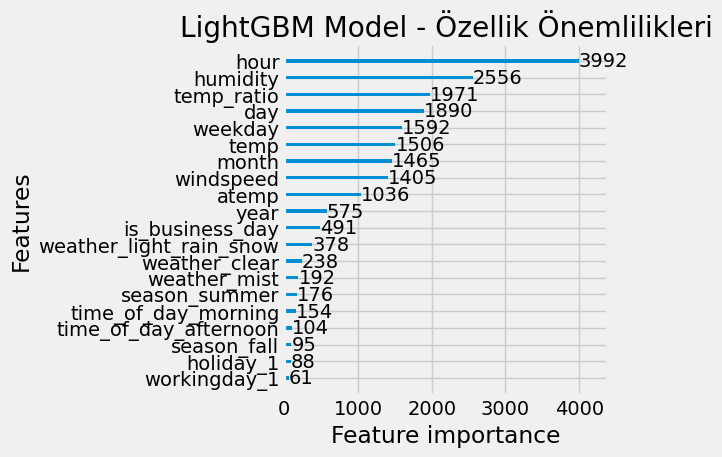

In [32]:
# Özellik önemlerini görselleştirme
plt.figure(figsize=(12, 10))
lgb.plot_importance(lgb_model, max_num_features=20)
plt.title('LightGBM Model - Özellik Önemlilikleri')
plt.tight_layout()
plt.show()

In [33]:
# En iyi modeli seçme - sonuçları karşılaştırma
models = {
    'Random Forest': (rf_model, rf_rmse),
    'Gradient Boosting': (gb_model, gb_rmse),
    'LightGBM': (lgb_model, lgb_rmse)
}

best_model_name = min(models, key=lambda k: models[k][1])
best_model, best_score = models[best_model_name]

print(f"\nEn iyi model: {best_model_name} - RMSLE: {best_score:.5f}")


En iyi model: LightGBM - RMSLE: 0.27122


In [34]:
# Test veri setini hazırlama
test_features = test[feature_columns].copy()
test_encoded = pd.get_dummies(test_features, columns=categorical_columns, drop_first=True)

In [35]:
# Eğitim ve test setlerinde sütunları hizala
missing_cols = set(X_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0
test_encoded = test_encoded[X_encoded.columns]

In [36]:
# En iyi model ile tahmin yapma
if best_model_name == 'LightGBM':
    y_pred_log = best_model.predict(test_encoded)
else:
    y_pred_log = best_model.predict(test_encoded)

In [37]:
# Logaritmik tahminleri orijinal ölçeğe dönüştürme
y_pred = np.expm1(y_pred_log)

In [38]:
submission = pd.DataFrame({
    'datetime': test['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S'),
    'count': y_pred
})

In [39]:
# Negatif değerleri 0 yap
submission['count'] = submission['count'].clip(lower=0)
# Tahminleri tam sayıya yuvarlama
submission['count'] = submission['count'].round().astype(int)

In [64]:
submission.to_csv('bike_sharing_submission.csv', index=False)